In [1]:
!pip install prophet
!pip install stan
!pip install pystan
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 455.6 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 396.6 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 14.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=731999 sha256=5d781c83bde2039d2c3318f69b8f03d2c69b9c35b96167ea1c4d9f7464ab797a
  Stored in directory: /home/onyxia/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ ex

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import stan
import nest_asyncio
nest_asyncio.apply()

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/business_is_business/main/England_covid.csv')

In [4]:
df = df[["date", "new_deaths_60days","new_virus_test","daily_cases"]]

In [5]:
df = df.dropna(axis=0)

In [6]:
df = df.sort_values(by='date')
df['j'] = np.arange(df.shape[0])
df["j"] = df['j'] + 1

def find_var_expl_time(j): 
    x_j = [1]
    x_j.append(j/365*3)
    for l in range(2,46): 
        if l >= 2 and l <= 8: 
            x_j.append(math.cos(2*math.pi*(l-2)*j/7))
        elif l >= 9 and l <= 15:
            x_j.append(math.sin(2*math.pi*(l-9)*j/7))
        elif l >= 16 and l <= 30: 
            x_j.append(math.cos(2*math.pi*(l-16)*j/(365.25)))
        elif l >= 31 and l <= 45:
            x_j.append(math.sin(2*math.pi*(l-35)*j/(365.25)))
    return x_j

mat_design = np.empty((0,46))
for j in df["j"]:
    row = np.array(find_var_expl_time(j))
    mat_design = np.r_[mat_design,[row]]

mat_design2 = pd.DataFrame(mat_design)

In [38]:
#Il faut fabriquer la variable p
df["positive_test_prop"] = df["daily_cases"] / df["new_virus_test"]

Intercept :  -15197050.139385467
Beta :  [ 1.44310041e+06  6.78579944e-04  8.38373517e+06 -3.79063743e+07
 -1.51527621e+09  5.44069412e+09 -5.44069412e+09  1.51527621e+09
  3.79063743e+07  6.66900694e+06 -3.76151907e+08  2.13695269e+09
 -7.30549818e+09 -7.30549818e+09  2.13695269e+09 -3.76151907e+08
  5.37021461e+06  1.25530208e-02 -4.70787618e-03 -5.05653499e-03
 -1.80814379e-02 -4.25979495e-03 -1.11603096e-03 -1.53590329e-03
 -2.09807966e-03 -1.24517614e-03 -8.17189459e-05  8.61762305e-04
  1.16021279e-03  6.96300041e-04  8.96105403e-04 -3.71736954e+06
  2.65166062e+06  2.14970111e+06 -8.50737148e+05  1.53476669e+05
 -8.50737161e+05  2.14970112e+06  2.65166063e+06 -3.71736952e+06
  2.77039161e-03 -3.74977646e-03 -3.49136628e-03 -3.46423007e-03
  2.80699826e-03  2.48216967e-03]


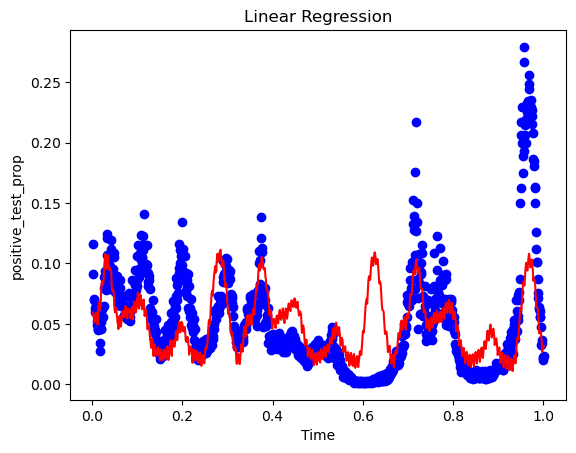

In [40]:
#Regression linéaire simple pour theta 2:
X = mat_design
y = df["positive_test_prop"]
model = LinearRegression().fit(X, y)

epsilon = model.intercept_
theta2 = model.coef_

print("Intercept : ",epsilon)
print("Beta : ", theta2)

T = df.shape[0]
t = np.array(df.index).reshape(-1, 1) / T


plt.scatter(t, df["positive_test_prop"], color='blue')
plt.plot(t, model.predict(X), color='red')
plt.xlabel('Time')
plt.ylabel('positive_test_prop')
plt.title('Linear Regression')
plt.show()

In [8]:
#Il faut aussi fabriquer le sigma 2
sigma2 = np.random.normal(loc=0, scale=np.sqrt(0.5))
sigma2 = np.exp(sigma2)

In [9]:
sigma2

0.8205297995855267

In [10]:
#génération de sessions aléatoires
import random

sessions = []
for i in range(1065):
    sessions.append(random.randint(1, 100000))

print(sessions)

[3657, 12409, 58035, 28710, 41246, 49780, 94788, 15250, 8401, 91809, 43325, 80129, 91891, 14876, 47735, 21446, 80795, 63187, 78830, 63876, 28378, 84585, 71651, 20262, 97235, 84433, 67208, 23410, 91814, 4134, 32385, 90899, 11420, 44619, 20856, 15840, 64992, 74345, 49488, 78554, 10359, 21907, 14703, 16245, 25506, 52064, 84152, 73072, 69686, 4472, 23490, 54279, 79619, 24501, 84234, 10744, 25040, 82197, 59331, 25796, 26478, 90857, 76480, 77150, 95032, 11871, 80084, 63419, 58108, 79370, 94094, 37972, 61459, 9554, 79616, 55344, 56119, 70984, 28197, 27779, 30626, 8015, 41683, 78790, 17426, 23349, 96767, 36373, 88056, 31225, 97389, 65328, 43212, 21228, 18306, 6594, 4488, 49347, 99892, 73531, 83714, 69278, 89027, 55287, 44478, 62970, 70477, 68167, 88940, 88467, 21551, 36512, 67041, 8562, 61454, 55975, 9998, 86127, 37749, 84098, 1788, 80694, 71438, 24083, 47980, 67924, 68217, 92555, 93117, 29711, 8912, 9294, 89666, 831, 37804, 32226, 45291, 84057, 50486, 33742, 77607, 55246, 15981, 99834, 79282,

In [28]:
#obligé de bien mettre le y sous format int
daily_cases_int = [int(nombre) for nombre in df["daily_cases"].values.tolist()]

In [29]:
Data = {"y": daily_cases_int,
                "N": len(y),
                "X": mat_design,
                "K" : mat_design.shape[1],
                "theta2" : theta2,
                "sigma2" : sigma2,
                "sessions" : sessions
       }

In [44]:
Model = """
data {
  int N; //nombre de données 
  int y[N]; //nombre de tests positifs
  int K; // nombre de colonnes de la matrice design
  real sigma2;
  matrix[N, K] X; //matrice design 
  vector[K] theta2;
  vector[N] sessions;
}
transformed parameters {
  vector[N] mu;
  vector[N] alpha;
  vector[N] beta; //
  mu = 1/(1+(atan((-X)*theta2)+2));
  alpha = mu*sigma2;
  beta = (1-mu)*sigma2;
}
model {
  for (i in 1:N) {
    y[i] ~ beta_binomial(1000, alpha[i], beta[i]);
  }
}
generated quantities {
  vector[N] y_rep;
  for (i in 1:N) {
    y_rep[i] = beta_binomial_rng(1000, alpha[i], beta[i]);
  }
}
"""

In [45]:
posterior = stan.build(Model, data=Data)

Building...

In file included from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/onyxia/.cache/httpstan/4.9.1/models/e4dst34c/model_e4dst34c.cpp:2:
/opt/mamba/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c


Building: 25.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_sy6wt2vs/model_e4dst34c.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_sy6wt2vs/model_e4dst34c.stan', line 21, column 25: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
